# Calibration


Import the necessary tools:

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import scipy

In [2]:
#############################################################
# Definition of parameters
#############################################################
# Get parameters from attributes
imgsDirectory = 'calibrationStereo/right*.png'
nbVertical = 6
nbHorizontal = 9
numberCornersFound = 0

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nbHorizontal*nbVertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nbVertical,0:nbHorizontal].T.reshape(-1,2) * 0.0336

# Arrays to store object points and image points from all the images.
objPoints = [] # 3d point in real world space
rightImgPoints = [] # 2d points in image plane.
leftImgPoints = []

# Read the images in this directory
images = glob.glob(imgsDirectory)
assert images

#############################################################
# Get corners of chessboard
#############################################################
# Finish process if no images are found
if len(images) == 0:        
    print("ERROR: No images found in this input: {}.".format(imgsDirectory))

#while False:
for fname in images:
    # First handle right image
    # Make image to gray scale
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # findChessboardCorners
    ret, corners = cv2.findChessboardCorners(gray, (nbVertical, nbHorizontal), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        numberCornersFound += 1
        objPoints.append(objp)

        corners_subpix = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        rightImgPoints.append(corners_subpix)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nbVertical, nbHorizontal), corners_subpix, ret)
        cv2.imshow('img',img)
        cv2.waitKey(100)

    # Then handle left image
    fname.replace('right', 'left')
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # findChessboardCorners
    ret, corners = cv2.findChessboardCorners(gray, (nbVertical, nbHorizontal), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        numberCornersFound += 1

        corners_subpix = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        leftImgPoints.append(corners_subpix)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nbVertical, nbHorizontal), corners_subpix, ret)
        cv2.imshow('img',img)
        cv2.waitKey(100)

cv2.destroyAllWindows()

#############################################################
# Compute calibration parameters
#############################################################
# Finish process if no corners are found
if numberCornersFound == 0:
    print("ERROR: No corners fit in any chessboard image.")
    
# Otherwise continue
# Compute the calibration parameters and show an example image if wanted
print("Found {} number of corners.".format(numberCornersFound))

Found 100 number of corners.


In [3]:
# Calibrate left camera
l_ret, l_mtx, l_dist, l_rvecs, l_tvecs = cv2.calibrateCamera(objPoints, leftImgPoints, img.shape[0:2][::-1], None, None)

# Calibrate right camera
r_ret, r_mtx, r_dist, r_rvecs, r_tvecs = cv2.calibrateCamera(objPoints, rightImgPoints, img.shape[0:2][::-1], None, None)

In [4]:
flags = cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_ZERO_TANGENT_DIST +cv2.CALIB_USE_INTRINSIC_GUESS +cv2.CALIB_SAME_FOCAL_LENGTH + \
            cv2.CALIB_RATIONAL_MODEL +cv2.CALIB_FIX_K3 + cv2.CALIB_FIX_K4 + cv2.CALIB_FIX_K5
# Stereo calibration
retval, mtx1, dist1, mtx2, dist2, R, T, E, F = \
    cv2.stereoCalibrate(objPoints, leftImgPoints, rightImgPoints, l_mtx, l_dist, r_mtx, r_dist, \
                        img.shape[0:2][::-1], flags=flags, criteria=criteria)

In [5]:
# Rectification
R1,R2,P1,P2,Q,_,_ = cv2.stereoRectify(mtx1, dist1, mtx2, dist2, img.shape[0:2][::-1], R, T, alpha=-1,\
                                      flags=cv2.CALIB_ZERO_DISPARITY)

Depth of pixel [400,600] in mm: 621.1981884119353


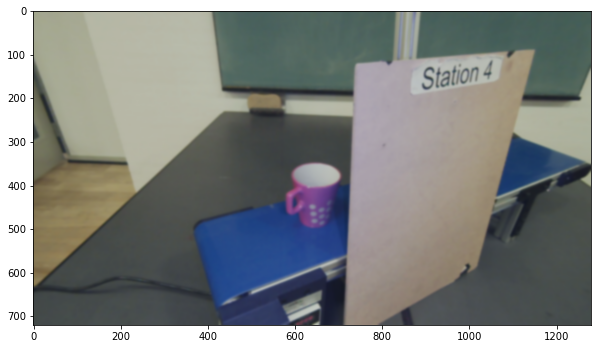

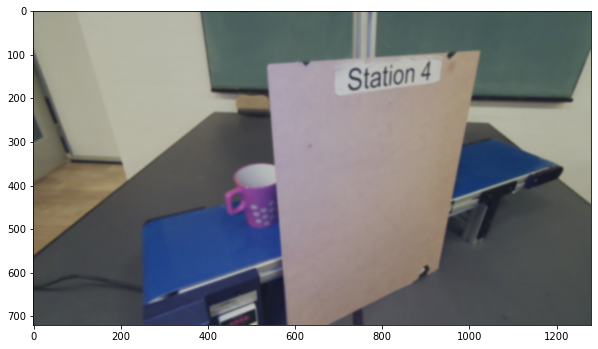

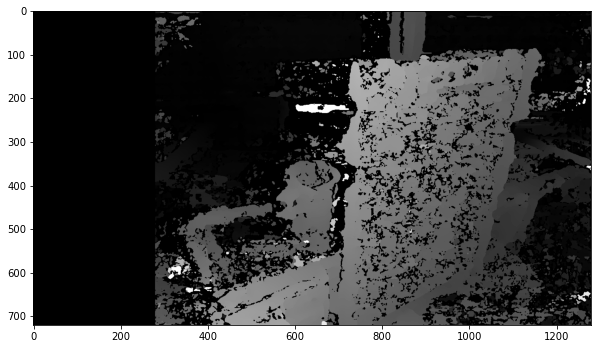

In [95]:
# Calibrate image as example
left = cv2.imread('distortedImagesWithOcclusion/left/1585434780_141374826_Left.png')
left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)

lH,  lW = left.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(l_mtx, l_dist, (lW, lH), 1, (lW, lH))

# Undistort
l_dst = cv2.GaussianBlur(cv2.undistort(left, mtx1, dist1, P1), (11,11), 0)
#l_dst = l_dst[100:200,:,:]
l_gray = cv2.cvtColor(l_dst, cv2.COLOR_RGB2GRAY)

# crop the image
# x, y, w, h = roi
# print(roi)
# l_dst = l_dst[y:y+h, x:x+w]
# plt.figure(figsize=(10,10))
# plt.imshow(left)
plt.figure(figsize=(10,10))

plt.imshow(l_dst)

# Calibrate image as example
right = cv2.imread('distortedImagesWithOcclusion/right/1585434780_141374826_Right.png')
right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
rH,  rW = left.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(r_mtx, r_dist, (rW, rH), 1, (rW, rH))

# Undistort
r_dst = cv2.GaussianBlur(cv2.undistort(right, r_mtx, r_dist, newcameramtx), (11,11), 0)
#r_dst = r_dst[100:200,:,:]
r_gray = cv2.cvtColor(r_dst, cv2.COLOR_RGB2GRAY)

# crop the image
# x, y, w, h = roi
# print(roi)
# r_dst = r_dst[y:y+h, x:x+w]
# plt.figure(figsize=(10,10))
# plt.imshow(right)
plt.figure(figsize=(10,10))

plt.imshow(r_dst)

# img_size = (int(l_gray.shape[1]/5), int(l_gray.shape[0]/5))
# l_gray = cv2.resize(l_gray, img_size, interpolation=cv2.INTER_AREA)
# r_gray = cv2.resize(r_gray, img_size, interpolation=cv2.INTER_AREA)

#stereo = cv2.StereoSGBM_create(numDisparities=256, blockSize=21)
stereo = cv2.StereoSGBM_create(minDisparity=24,
                               numDisparities=256,
                               blockSize=11,
                               P1=500,
                               P2=2000,
                               #disp12MaxDiff=500,
                               #preFilterCap=50,
                               uniquenessRatio=5)

#stereo.setMinDisparity(25)
## stereo.setDisp12MaxDiff(500)
#stereo.setUniquenessRatio(1)
## stereo.setSpeckleRange(3)
## stereo.setSpeckleWindowSize(5)

plt.figure(figsize=(10,10))
disparity = stereo.compute(l_gray,r_gray)#.astype(np.float32) / 16.0
plt.imshow(disparity,'gray')
print(f"Depth of pixel [400,600] in mm: {mtx1[0,0]*120/(disparity[400,600]/16.0)}")

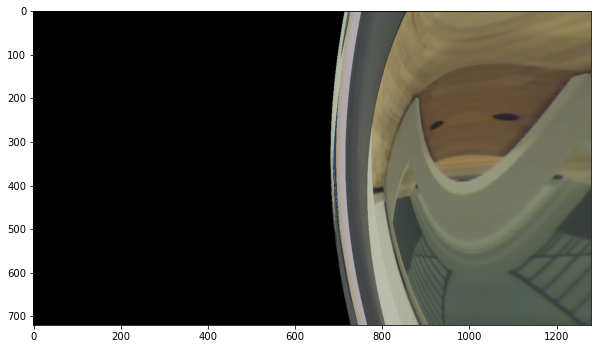

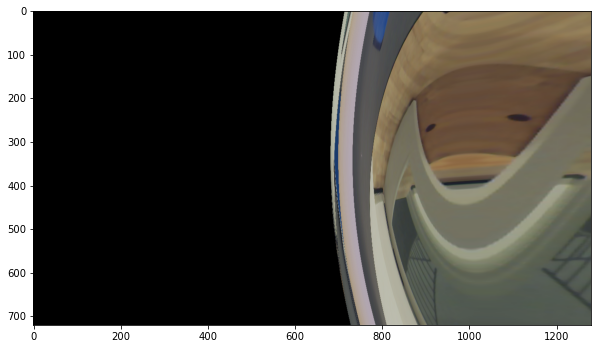

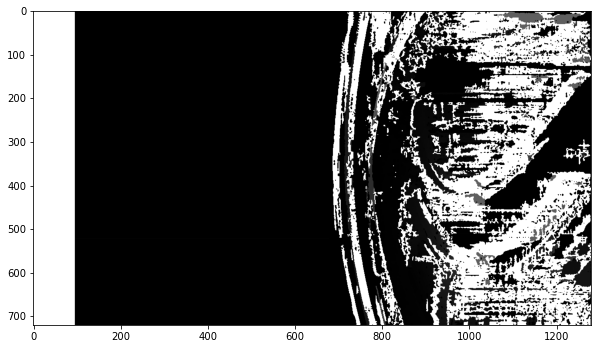

In [15]:
mx1, my1 = cv2.initUndistortRectifyMap(mtx1, dist1, R1, P1, img.shape[0:2][::-1], cv2.CV_32FC1)
mx2, my2 = cv2.initUndistortRectifyMap(mtx2, dist2, R2, P2, img.shape[0:2][::-1], cv2.CV_32FC1)

# stereo_disparity = cv2.StereoBM_create(numDisparities=64, blockSize=13)
window_size = 3
stereo_disparity = cv2.StereoSGBM_create(minDisparity=0,
        numDisparities=96,
        blockSize=window_size,
        P1=8*5*window_size**2,
        P2=16 * 5 * window_size ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=0,
        speckleRange=2,
        preFilterCap=63,
       mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )


lmbda = 100000
sigma = 1.0
visual_multiplier = 1.0

wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)
    
left = cv2.imread('undistortedImagesWithOcclusion/left/1585434750_405124664_Left.png')
right = cv2.imread('undistortedImagesWithOcclusion/right/1585434750_405124664_Right.png')
img1 = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    
img1_rm = cv2.remap(left, mx1, my1, cv2.INTER_LINEAR)
img2_rm = cv2.remap(right, mx2, my2, cv2.INTER_LINEAR)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img1_rm, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img2_rm, cv2.COLOR_BGR2RGB))

disparity_map = stereo_disparity.compute(img1_rm, img2_rm)
cv2.filterSpeckles(disparity_map, 0, 64, 32)

plt.figure(figsize=(10,10))
plt.imshow((disparity_map / 16.).astype(np.uint8), 'gray')

